In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/mloscratch/homes/yixuan/PDM')

In [4]:
import numpy as np
from datasets import load_dataset
from tqdm import tqdm
from utils.edit_distance import compute_ngram_distance_damerau_levenshtein
from utils.LCS import find_longest_common_substrings
from utils.exact_match import CommonSubstringMatcher

In [5]:
import pickle 
import os

# Using pickle (better for complex Python objects)
def save_results(results, save_path):
    """
    Save results dictionary to a file
    
    Parameters
    ----------
    results : dict
        Dictionary containing results
    save_path : str
        Path to save the results (e.g., 'results/data.pkl')
    """
    # Create directory if it doesn't exist
    save_dir = os.path.dirname(save_path)
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        
    with open(save_path, 'wb') as f:
        pickle.dump(results, f)

In [8]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset

def get_checkpoints(expr_base_dir):
    """
    Get sorted checkpoints from directory
    
    Parameters
    ----------
    expr_base_dir : str
        Base directory containing checkpoints
        
    Returns
    -------
    list
        Sorted list of (step, consumed) tuples
    """
    return sorted([(int(f.name.split('=')[1].split('-')[0]), int(f.name.split('=')[2]))
                  for f in Path(expr_base_dir).glob("step=*")])

def load_inference_data(base_dir, step, consumed):
    """
    Load inference data from a given step and restore original data order.
    DistributedSampler distributes data in round-robin fashion (e.g., GPU0: [0,8,16,...], GPU1: [1,9,17,...]).
    This function loads data from all rank files and reorders it back to sequential order [0,1,2,...].
    
    Parameters
    ----------
    base_dir : str
        Base directory path 
    step : int
        Training step
    consumed : int
        Number of consumed tokens
        
    Returns
    -------
    Dataset
        HuggingFace dataset with data restored to original sequential order
    """
    file_path = Path(base_dir) / f"step={step}-consumed={consumed}"
    rank_files = sorted(file_path.glob("rank*.jsonl"))
    world_size = len(rank_files)

    # Load data from all ranks
    dataset = load_dataset(
        'json', 
        data_files=[str(f) for f in rank_files], 
        split='train'
    )
    
    total_size = len(dataset)
    items_per_rank = total_size // world_size

    # Reorder to original sequential order
    orig_indices = np.arange(total_size).reshape(world_size, items_per_rank).T.flatten()
    
    return dataset.select(orig_indices)

In [7]:
def calc_avg_lcs_lengths(base_dir, model_ids):
    """
    Calculate average LCS lengths for multiple models with data split into train/val/test
    
    Parameters
    ----------
    base_dir : str
        Base directory containing all model results
    model_ids : list
        List of model identifiers to process
        
    Returns
    -------
    dict
        Dictionary mapping model names to their results with split information
    """
    results = {}
    for model_id in model_ids:
        expr_dir = f"{base_dir}/{model_id}"
        ckpts = get_checkpoints(expr_dir)
        
        steps, avg_lengths = [], []
        for step, consumed in tqdm(ckpts, desc=f"Processing {model_id}"):
            data = load_inference_data(expr_dir, step, consumed)
            
            # Calculate split indices
            n_total = len(data['true_suffix'])
            n_train = int(n_total * 0.9)
            n_val = int(n_total * 0.05)
            
            # Split data
            splits = {
                'train': {
                    'true_suffix': data['true_suffix'][:n_train],
                    'generated_suffix': data['generated_suffix'][:n_train]
                },
                'val': {
                    'true_suffix': data['true_suffix'][n_train:n_train + n_val],
                    'generated_suffix': data['generated_suffix'][n_train:n_train + n_val]
                },
                'test': {
                    'true_suffix': data['true_suffix'][n_train + n_val:],
                    'generated_suffix': data['generated_suffix'][n_train + n_val:]
                }
            }
            
            # Calculate LCS for each split
            lcs_results = {}
            for split_name, split_data in splits.items():
                lcs_res = find_longest_common_substrings(
                    split_data['true_suffix'], 
                    split_data['generated_suffix']
                )
                lcs_results[split_name] = lcs_res.max_length.mean()
            
            steps.append(step)
            avg_lengths.append(lcs_results)
            
        # Reorganize results by split
        split_results = {
            'train': {'steps': steps, 'avg_lengths': [r['train'] for r in avg_lengths]},
            'val': {'steps': steps, 'avg_lengths': [r['val'] for r in avg_lengths]},
            'test': {'steps': steps, 'avg_lengths': [r['test'] for r in avg_lengths]}
        }
        
        results[model_id] = split_results
    
    return results

In [8]:
def plot_comparison(results, include_ckpts=None, include_splits=None, title=None, log_y=False):
   """
   Plot comparison of models with train/val/test splits
   
   Parameters
   ----------
   results : dict
       Dictionary containing results for each model and split
   include_ckpts : list, optional
       List of model IDs to include in plotting. If None, includes all models.
   include_splits : list, optional
       List of split names to include in plotting. If None, includes all splits.
   title : str, optional
       Custom title for the plot. If None, uses default title.
   log_y : bool, optional
       Whether to use log scale for y-axis
       
   Examples
   --------
   >>> # Plot all models and splits
   >>> plot_comparison(results)
   
   >>> # Include only specific models and splits
   >>> plot_comparison(results, 
   ...                include_ckpts=['llama_1.5B_Standard'],
   ...                include_splits=['train', 'val'])
   
   >>> # Custom title and log scale
   >>> plot_comparison(results,
   ...                title='Model Comparison',
   ...                log_y=True)
   """
   plt.figure(figsize=(12, 6))
   
   # Line styles for different splits
   all_styles = {
       'train': '-',
       'val': '--',
       'test': ':'
   }
   
   # Filter splits to include
   styles = all_styles if include_splits is None else {
       k: v for k, v in all_styles.items() if k in include_splits
   }
   
   # Filter models and plot
   models_to_plot = results.keys() if include_ckpts is None else include_ckpts
   
   for model_name in models_to_plot:
       if model_name not in results:
           continue
           
       model_results = results[model_name]
       
       # Plot each included split
       for split_name, style in styles.items():
           split_data = model_results[split_name]
           
           # Convert steps to epochs
           epochs = [step/75 for step in split_data['steps']]
           
           plt.plot(epochs, split_data['avg_lengths'],
                   linestyle=style,
                   marker='o', 
                   label=f'{model_name} ({split_name})',
                   alpha=0.7)
   
   plt.xlabel('Training Epochs')
   plt.ylabel('Average Memorisation Length')
   
   # Use custom title if provided, otherwise use default
   plot_title = title if title else 'Average Longest Verbatim Memorisation Length vs Training Epochs'
   plt.title(plot_title)
   
   # Set y-axis to log scale if requested
   if log_y:
       plt.yscale('log')
   
   plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
   plt.grid(True)
   plt.tight_layout()
   
   plt.show()

In [6]:
base_dir = "/mloscratch/homes/yixuan/PDM/inference"
model_ids = [
    "llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93",
    "llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83",
    "llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79",
    "llama_1.5B_Standard_GBS_120_EPOCH_75"
]
results = calc_avg_lcs_lengths(base_dir, model_ids)

Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:   0%|          | 0/23 [00:00<?, ?it/s]

Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:   4%|▍         | 1/23 [00:18<06:48, 18.57s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.07 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.07 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:   9%|▊         | 2/23 [00:39<06:56, 19.85s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  13%|█▎        | 3/23 [00:57<06:19, 18.97s/it]

Time taken: 1.41 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  17%|█▋        | 4/23 [01:17<06:07, 19.34s/it]

Time taken: 1.44 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  22%|██▏       | 5/23 [01:34<05:38, 18.80s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  26%|██▌       | 6/23 [01:52<05:13, 18.46s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  30%|███       | 7/23 [02:10<04:51, 18.23s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  35%|███▍      | 8/23 [02:28<04:30, 18.06s/it]

Time taken: 1.41 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  39%|███▉      | 9/23 [02:45<04:10, 17.92s/it]

Time taken: 1.53 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  43%|████▎     | 10/23 [03:03<03:51, 17.81s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  48%|████▊     | 11/23 [03:20<03:32, 17.70s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  52%|█████▏    | 12/23 [03:38<03:15, 17.80s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  57%|█████▋    | 13/23 [03:57<03:01, 18.18s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  61%|██████    | 14/23 [04:15<02:41, 17.98s/it]

Time taken: 1.41 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  65%|██████▌   | 15/23 [04:33<02:23, 17.94s/it]

Time taken: 1.45 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  70%|██████▉   | 16/23 [04:51<02:05, 17.95s/it]

Time taken: 1.55 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  74%|███████▍  | 17/23 [05:09<01:47, 17.90s/it]

Time taken: 1.46 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  78%|███████▊  | 18/23 [05:27<01:29, 17.99s/it]

Time taken: 1.47 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...
Time taken: 1.55 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  83%|████████▎ | 19/23 [05:45<01:12, 18.07s/it]

Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  87%|████████▋ | 20/23 [06:03<00:54, 18.01s/it]

Time taken: 1.41 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  91%|█████████▏| 21/23 [06:21<00:36, 18.12s/it]

Time taken: 1.52 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  96%|█████████▌| 22/23 [06:39<00:18, 18.05s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93: 100%|██████████| 23/23 [06:57<00:00, 18.15s/it]


Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:   0%|          | 0/21 [00:00<?, ?it/s]

Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:   5%|▍         | 1/21 [00:17<05:50, 17.54s/it]

Time taken: 1.44 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  10%|▉         | 2/21 [00:35<05:32, 17.49s/it]

Time taken: 1.38 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  14%|█▍        | 3/21 [00:52<05:16, 17.58s/it]

Time taken: 1.41 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...
Time taken: 1.54 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  19%|█▉        | 4/21 [01:10<05:00, 17.66s/it]

Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  24%|██▍       | 5/21 [01:27<04:40, 17.54s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  29%|██▊       | 6/21 [01:45<04:23, 17.55s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  33%|███▎      | 7/21 [02:03<04:06, 17.64s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...
Time taken: 1.53 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  38%|███▊      | 8/21 [02:20<03:49, 17.66s/it]

Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  43%|████▎     | 9/21 [02:38<03:31, 17.64s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  48%|████▊     | 10/21 [02:55<03:13, 17.59s/it]

Time taken: 1.41 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  52%|█████▏    | 11/21 [03:13<02:55, 17.54s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  57%|█████▋    | 12/21 [03:30<02:37, 17.54s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  62%|██████▏   | 13/21 [03:48<02:20, 17.57s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  67%|██████▋   | 14/21 [04:06<02:03, 17.59s/it]

Time taken: 1.47 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  71%|███████▏  | 15/21 [04:23<01:45, 17.52s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  76%|███████▌  | 16/21 [04:41<01:27, 17.49s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  81%|████████  | 17/21 [04:58<01:10, 17.55s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  86%|████████▌ | 18/21 [05:16<00:52, 17.63s/it]

Time taken: 1.41 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  90%|█████████ | 19/21 [05:34<00:35, 17.68s/it]

Time taken: 1.46 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  95%|█████████▌| 20/21 [05:52<00:17, 17.71s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83: 100%|██████████| 21/21 [06:09<00:00, 17.62s/it]


Time taken: 1.44 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:   0%|          | 0/19 [00:00<?, ?it/s]

Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:   5%|▌         | 1/19 [00:17<05:11, 17.32s/it]

Time taken: 1.34 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.07 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.07 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  11%|█         | 2/19 [00:34<04:57, 17.50s/it]

Time taken: 1.38 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...
Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  16%|█▌        | 3/19 [00:52<04:39, 17.46s/it]

Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  21%|██        | 4/19 [01:09<04:22, 17.49s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  26%|██▋       | 5/19 [01:27<04:04, 17.49s/it]

Time taken: 1.41 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  32%|███▏      | 6/19 [01:45<03:49, 17.65s/it]

Time taken: 1.44 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  37%|███▋      | 7/19 [02:03<03:33, 17.77s/it]

Time taken: 1.46 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  42%|████▏     | 8/19 [02:21<03:15, 17.80s/it]

Time taken: 1.46 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  47%|████▋     | 9/19 [02:38<02:57, 17.73s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  53%|█████▎    | 10/19 [02:56<02:39, 17.68s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  58%|█████▊    | 11/19 [03:14<02:21, 17.71s/it]

Time taken: 1.46 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  63%|██████▎   | 12/19 [03:31<02:03, 17.65s/it]

Time taken: 1.44 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  68%|██████▊   | 13/19 [03:49<01:46, 17.71s/it]

Time taken: 1.46 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  74%|███████▎  | 14/19 [04:06<01:28, 17.64s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  79%|███████▉  | 15/19 [04:24<01:10, 17.61s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  84%|████████▍ | 16/19 [04:41<00:52, 17.57s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...
Time taken: 1.54 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  89%|████████▉ | 17/19 [04:59<00:35, 17.68s/it]

Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...
Time taken: 1.52 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  95%|█████████▍| 18/19 [05:17<00:17, 17.68s/it]

Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79: 100%|██████████| 19/19 [05:35<00:00, 17.64s/it]


Time taken: 1.41 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:   0%|          | 0/19 [00:00<?, ?it/s]

Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:   5%|▌         | 1/19 [00:17<05:11, 17.29s/it]

Time taken: 1.36 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  11%|█         | 2/19 [00:34<04:55, 17.40s/it]

Time taken: 1.47 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  16%|█▌        | 3/19 [00:52<04:38, 17.43s/it]

Time taken: 1.41 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  21%|██        | 4/19 [01:09<04:22, 17.52s/it]

Time taken: 1.52 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  26%|██▋       | 5/19 [01:27<04:05, 17.53s/it]

Time taken: 1.53 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  32%|███▏      | 6/19 [01:44<03:47, 17.49s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  37%|███▋      | 7/19 [02:02<03:30, 17.54s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...
Time taken: 1.57 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  42%|████▏     | 8/19 [02:20<03:14, 17.65s/it]

Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  47%|████▋     | 9/19 [02:38<02:56, 17.65s/it]

Time taken: 1.44 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  53%|█████▎    | 10/19 [02:55<02:39, 17.70s/it]

Time taken: 1.55 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  58%|█████▊    | 11/19 [03:13<02:22, 17.82s/it]

Time taken: 1.50 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  63%|██████▎   | 12/19 [03:31<02:04, 17.83s/it]

Time taken: 1.62 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  68%|██████▊   | 13/19 [03:49<01:46, 17.77s/it]

Time taken: 1.50 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...
Time taken: 1.62 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  74%|███████▎  | 14/19 [04:07<01:28, 17.74s/it]

Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  79%|███████▉  | 15/19 [04:24<01:10, 17.71s/it]

Time taken: 1.56 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...
Time taken: 1.66 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  84%|████████▍ | 16/19 [04:43<00:53, 17.88s/it]

Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  89%|████████▉ | 17/19 [05:00<00:35, 17.86s/it]

Time taken: 1.55 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  95%|█████████▍| 18/19 [05:18<00:17, 17.91s/it]

Time taken: 1.64 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75: 100%|██████████| 19/19 [05:36<00:00, 17.73s/it]

Time taken: 1.63 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds


In [9]:
with open('/mloscratch/homes/yixuan/PDM/results/avg_lcs.pkl', 'rb') as f:
    lcs_results = pickle.load(f)

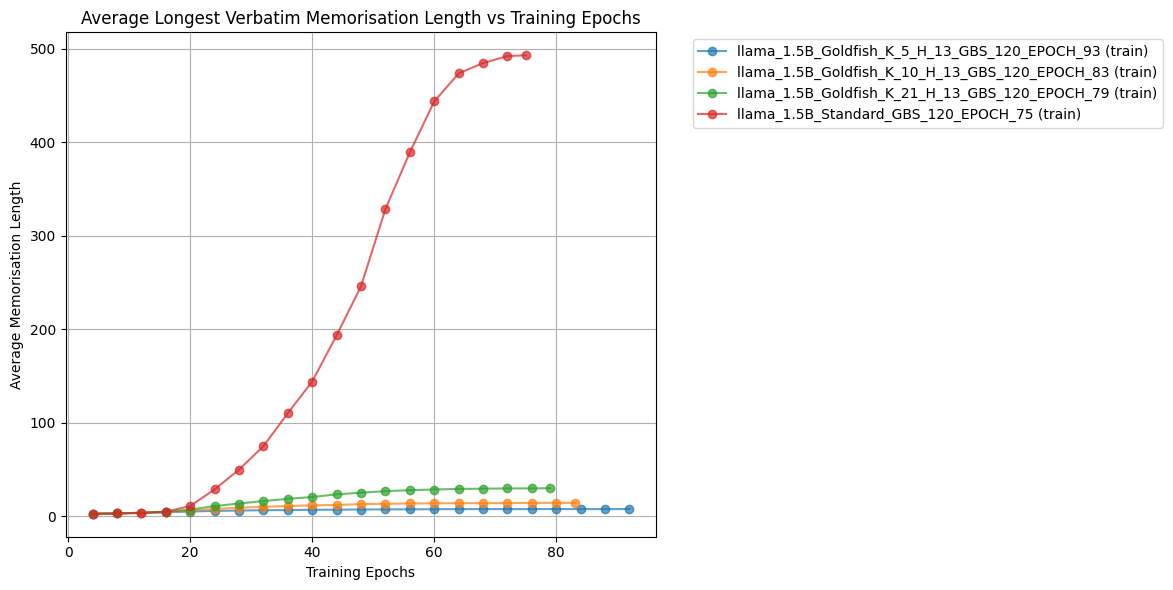

In [11]:
plot_comparison(
    results=lcs_results, 
    include_ckpts=[
        "llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93",
        "llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83",
        "llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79",
        "llama_1.5B_Standard_GBS_120_EPOCH_75"
    ], 
    include_splits=[
        'train', 
        # 'val', 
        # 'test'
    ],
    title='Average Longest Verbatim Memorisation Length vs Training Epochs'
)

In [16]:
save_results(results, '../results/avg_lcs.pkl')

In [11]:
def calc_avg_cs_lengths(base_dir, model_ids):
    """
    Calculate average common substring lengths for multiple models with data split into train/val/test
    
    Parameters
    ----------
    base_dir : str
        Base directory containing all model results
    model_ids : list
        List of model identifiers to process
        
    Returns
    -------
    dict
        Dictionary mapping model names to their results with split information
    """
    results = {}
    for model_id in model_ids:
        expr_dir = f"{base_dir}/{model_id}"
        ckpts = get_checkpoints(expr_dir)
        
        steps, avg_lengths = [], []
        for step, consumed in tqdm(ckpts, desc=f"Processing {model_id}"):
            data = load_inference_data(expr_dir, step, consumed)
            
            # Calculate split indices
            n_total = len(data['true_suffix'])
            n_train = int(n_total * 0.9)
            n_val = int(n_total * 0.05)
            
            # Split data
            splits = {
                'train': {
                    'true_suffix': data['true_suffix'][:n_train],
                    'generated_suffix': data['generated_suffix'][:n_train]
                },
                'val': {
                    'true_suffix': data['true_suffix'][n_train:n_train + n_val],
                    'generated_suffix': data['generated_suffix'][n_train:n_train + n_val]
                },
                'test': {
                    'true_suffix': data['true_suffix'][n_train + n_val:],
                    'generated_suffix': data['generated_suffix'][n_train + n_val:]
                }
            }
            
            # Calculate CS for each split
            cs_results = {}
            for split_name, split_data in splits.items():
                cs_master = CommonSubstringMatcher(
                    split_data['true_suffix'], 
                    split_data['generated_suffix']
                )
                matches = cs_master.get_all_matches()
                # Using nanmean for samples with all None matches
                cs_results[split_name] = np.nanmean([
                    np.mean([match.length if match is not None else 0 for match in sample])
                    for sample in matches
                ])
            
            steps.append(step)
            avg_lengths.append(cs_results)
            
        # Reorganize results by split
        split_results = {
            'train': {'steps': steps, 'avg_lengths': [r['train'] for r in avg_lengths]},
            'val': {'steps': steps, 'avg_lengths': [r['val'] for r in avg_lengths]},
            'test': {'steps': steps, 'avg_lengths': [r['test'] for r in avg_lengths]}
        }
        
        results[model_id] = split_results
    
    return results

In [ ]:
base_dir = "/mloscratch/homes/yixuan/PDM/inference"
model_ids = [
    "llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93",
    "llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83",
    "llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79",
    "llama_1.5B_Standard_GBS_120_EPOCH_75"
]
cs_results = calc_avg_cs_lengths(base_dir, model_ids)

In [30]:
with open('/mloscratch/homes/yixuan/PDM/results/avg_cs.pkl', 'rb') as f:
    cs_results = pickle.load(f)

In [1]:
plot_comparison(
    results=cs_results, 
    include_ckpts=[
        "llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93",
        "llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83",
        "llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79",
        "llama_1.5B_Standard_GBS_120_EPOCH_75"
    ], 
    include_splits=[
        'train', 
        # 'val', 
        # 'test'
    ],
    title='Average Verbatim Memorisation Length vs Training Epochs'
)

NameError: name 'plot_comparison' is not defined

In [10]:
with open('/mloscratch/homes/yixuan/PDM/results/avg_cs.pkl', 'rb') as f:
    results = pickle.load(f)

In [9]:
split_data = load_inference_data("/mloscratch/homes/yixuan/PDM/inference/llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93", 300, 36000)

In [10]:
split_data

Dataset({
    features: ['prefix', 'true_suffix', 'generated_suffix'],
    num_rows: 10000
})

In [11]:
res = find_longest_common_substrings(
    split_data['true_suffix'], 
    split_data['generated_suffix']
)

Warming up Numba JIT...
Processing 10000 sequence pairs in parallel...
Time taken: 1.51 seconds


In [13]:
cs_master = CommonSubstringMatcher(
                    split_data['true_suffix'], 
                    split_data['generated_suffix']
                )
matches = cs_master.get_all_matches()

Computed DP matrices in 2.80 seconds.


Finding matches: 100%|██████████| 10000/10000 [00:14<00:00, 697.21sequence/s]


In [15]:
matches[0]

[Match(idx=0, length=2, s1[215:217], s2[439:441]), values=[315 279]),
 Match(idx=0, length=2, s1[215:217], s2[448:450]), values=[315 279]),
 Match(idx=0, length=2, s1[215:217], s2[454:456]), values=[315 279]),
 Match(idx=0, length=2, s1[215:217], s2[463:465]), values=[315 279]),
 Match(idx=0, length=2, s1[215:217], s2[469:471]), values=[315 279]),
 Match(idx=0, length=2, s1[215:217], s2[478:480]), values=[315 279]),
 Match(idx=0, length=2, s1[215:217], s2[484:486]), values=[315 279]),
 Match(idx=0, length=2, s1[215:217], s2[493:495]), values=[315 279]),
 Match(idx=0, length=2, s1[232:234], s2[2:4]), values=[315 279]),
 Match(idx=0, length=2, s1[232:234], s2[17:19]), values=[315 279]),
 Match(idx=0, length=2, s1[232:234], s2[35:37]), values=[315 279]),
 Match(idx=0, length=2, s1[232:234], s2[44:46]), values=[315 279]),
 Match(idx=0, length=2, s1[232:234], s2[61:63]), values=[315 279]),
 Match(idx=0, length=2, s1[232:234], s2[74:76]), values=[315 279]),
 Match(idx=0, length=2, s1[232:234

In [5]:
from numba import njit


In [11]:
@njit
def _dp_edit_distance_band(s1: np.ndarray, s2: np.ndarray, max_edits: int) -> np.ndarray:
    """Optimized band version with simpler logic."""
    m, n = len(s1), len(s2)
    dp = np.full((m + 1, n + 1), max_edits + 1, dtype=np.int32)
    
    # Initialize base cases
    dp[0, 0] = 0
    for i in range(1, min(m + 1, max_edits + 1)):
        dp[i, 0] = i
    for j in range(1, min(n + 1, max_edits + 1)):
        dp[0, j] = j
    
    # Fill DP table within band
    for i in range(1, m + 1):
        j_start = max(1, i - max_edits)
        j_end = min(n + 1, i + max_edits + 1)
        
        for j in range(j_start, j_end):
            if s1[i - 1] == s2[j - 1]:
                dp[i, j] = dp[i - 1, j - 1]
            else:
                dp[i, j] = min(
                    dp[i - 1, j] + 1,
                    dp[i, j - 1] + 1,
                    dp[i - 1, j - 1] + 1
                )
                # Check for transposition
                if (i > 1 and j > 1 and 
                    s1[i - 1] == s2[j - 2] and 
                    s1[i - 2] == s2[j - 1]):
                    dp[i, j] = min(dp[i, j], dp[i - 2, j - 2] + 1)
    
    return dp

In [12]:
# Example usage
s1 = [1, 2, 4, 3, 5, 6, 7, 11, 9, 10, 12, 13, 15, 14, 16, 17, 18, 20, 19]
s2 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 16, 17, 18, 19, 20]
max_edits = 4
dp = _dp_edit_distance_band(s1, s2, max_edits)

In [13]:
dp

array([[0, 1, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       [1, 0, 1, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       [2, 1, 0, 1, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       [3, 2, 1, 1, 1, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       [4, 3, 2, 1, 1, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       [5, 4, 3, 2, 2, 1, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       [5, 5, 4, 3, 3, 2, 1, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       [5, 5, 5, 4, 4, 3, 2, 1, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5, 4, 3, 2, 2, 3, 4, 5, 6, 5, 5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5, 5, 4, 3, 3, 2, 3, 4, 5, 6, 5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5, 5, 5, 4, 4, 3, 2, 3, 4, 5, 6, 5, 5, 5, 5],
       [5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 3, 2, 3, 4, 5, 6, 5, 5, 5],
       [5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 4, 3, 2, 3, 4, 5, 6, 5, 5],
       [5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 4, 3, 3, 4, 5, 6, 6, 5],
       [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 4, 3, 4, 5, 6, 7, 6],
       [5,